In [2]:
import os, sys
sys.path.append('../')
from xd import *
from run_DMASS import *
from utils import *
import esutil
import healpy as hp
from systematics import *
import fitsio

%matplotlib inline

%load_ext autoreload
%autoreload 2

In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [3]:
# calling map 
path = '/fs/scratch/PCON0003/warner785/bwarner/'
LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_redlimcut_il22_seeil4.0_4096ring.fits')
# 'Y1LSSmask_v2_redlimcut_il22_seeil4.0_4096ring.fits'
#GoldMask = callingEliGoldMask()
LSSMask = LSSGoldmask
GoldMask = LSSGoldmask
LSSMask = LSSMask[LSSMask['DEC']>-3.0 ]
#GoldMask_st82 = Cuts.SpatialCuts(GoldMask, ra=320, ra2=360, dec=-2, dec2=2)
GoldMask_st82 = GoldMask[ GoldMask['DEC'] > -3.0 ]
GoldMask_spt = GoldMask[ GoldMask['DEC'] < -3.0 ]
#GoldMask_spt = Cuts.SpatialCuts(GoldMask_spt, ra=0, ra2 = 100, dec=-52, dec2 = -48)

pixarea = hp.nside2pixarea( 4096, degrees = True)
sptnpix = GoldMask_spt['PIXEL'].size #hp.get_map_size( GoldMask_spt['PIXEL'] )
st82npix =  GoldMask_st82['PIXEL'].size # hp.get_map_size( GoldMask_st82 )
SPTMaparea = pixarea * sptnpix
ST82Maparea = pixarea * st82npix

In [4]:
rootdir = '../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5_validate/'

# Directory doesn't exist ---- create 
# check for error: print statement 
import os
outdir = '../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5_validate//'
if os.path.exists(outdir) == False:
    os.mkdir(outdir)
rootdir = '../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5_validate/'

In [5]:
#implement Cuts.keepgoodregion:

def keepGoodRegion(des, hpInd = False, balrog=None):
    import healpy as hp
    import fitsio
    # 25 is the faintest object detected by DES
    # objects larger than 25 considered as Noise
    
    path = '/fs/scratch/PCON0003/warner785/bwarner/'
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_il22_seeil4.0_nside4096ring_redlimcut.fits')
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits')
    LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_redlimcut_il22_seeil4.0_4096ring.fits')
    #Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits
    #frac_cut = LSSGoldmask['FRAC'] > 0.8
    #ind_good_ring = LSSGoldmask['PIXEL'][frac_cut]
    ind_good_ring = LSSGoldmask['PIXEL']
    
    # healpixify the catalog.
    nside=4096
    # Convert silly ra/dec to silly HP angular coordinates.
    phi = des['RA'] * np.pi / 180.0
    theta = ( 90.0 - des['DEC'] ) * np.pi/180.0

    hpInd = hp.ang2pix(nside,theta,phi,nest=False)
    keep = np.in1d(hpInd, ind_good_ring)
    des = des[keep]
    if hpInd is True:
        return ind_good_ring
    else:
        return des
    
#gold_st82 = keepGoodRegion(gold_st82)
#print(gold_st82.size)
#gold_spt = keepGoodRegion(gold_spt)
#print(gold_spt.size)

In [6]:
# calling BOSS cmass and applying dmass goodregion mask ----------------------------
#cmass = io.getSGCCMASSphotoObjcat()
train_sample = esutil.io.read('/fs/scratch/PCON0003/warner785/bwarner/cmass-dr12v4-S-Reid-full.dat.fits')
print('total num of train', train_sample.size)
print('\n--------------------------------\n applying DES veto mask to CMASS\n--------------------------------')
train_sample = keepGoodRegion(train_sample)
print('total num of train', train_sample.size)

total num of train 258884

--------------------------------
 applying DES veto mask to CMASS
--------------------------------
total num of train 13046


In [7]:
#read in gold catalogs here:
##ST82 REGION catalog:

train_path = '/fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/'
path =  train_path
train_keyword = 'Y1A1_GOLD_STRIPE82_v2'
    
columns = ['FLAGS_GOLD', 'FLAGS_BADREGION', 'MAG_MODEL_G', 'MAG_MODEL_R', 'MAG_MODEL_I', 'MAG_MODEL_Z',\
               'MAG_DETMODEL_G', 'MAG_DETMODEL_R', 'MAG_DETMODEL_I', 'MAG_DETMODEL_Z', 'MAGERR_DETMODEL_G',\
               'MAGERR_DETMODEL_R', 'MAGERR_DETMODEL_I', 'MAGERR_DETMODEL_Z', 'MAGERR_MODEL_G', 'MAGERR_MODEL_R',\
               'MAGERR_MODEL_I', 'MAGERR_MODEL_Z', 'MAG_AUTO_G', 'MAG_AUTO_R', 'MAG_AUTO_I', 'MAG_AUTO_Z', 'RA',\
               'DEC', 'COADD_OBJECTS_ID', 'MODEST_CLASS', 'HPIX', 'DESDM_ZP',\
               'SLR_SHIFT_G', 'SLR_SHIFT_R', 'SLR_SHIFT_I', 'SLR_SHIFT_Z', 'SLR_SHIFT_Y', 'EBV']

gold_st82 = io.SearchAndCallFits(path = train_path, columns = columns, keyword = train_keyword )
gold_st82 = gold_st82[(gold_st82['MODEST_CLASS'] == 1)&(gold_st82['FLAGS_GOLD'] == 0 )]

gold_st82 = keepGoodRegion(gold_st82)
    
def RemovingSLRReddening(cat):


    if 'SLR_SHIFT_G' not in cat.dtype.names : 
        import numpy.lib.recfunctions as rf   
        #from suchyta_utils.y1a1_slr_shiftmap import SLRShift
        from y1a1_slr_shiftmap import SLRShift
        zpfile = '/fs/scratch/PCON0003/warner785/bwarner/y1a1_wide_slr_wavg_zpshift2.fit'
        slrshift = SLRShift(zpfile, fill_periphery=True)
        offsets_g = slrshift.get_zeropoint_offset('g',cat['RA'],cat['DEC'],interpolate=True)
        offsets_r = slrshift.get_zeropoint_offset('r',cat['RA'],cat['DEC'],interpolate=True)
        offsets_i = slrshift.get_zeropoint_offset('i',cat['RA'],cat['DEC'],interpolate=True)
        offsets_z = slrshift.get_zeropoint_offset('z',cat['RA'],cat['DEC'],interpolate=True)

        offsets = [ offsets_g, offsets_r, offsets_i, offsets_z  ]
        from pandas import DataFrame, concat
        nametag = ['SLR_SHIFT_'+f for f in ['G', 'R', 'I', 'Z'] ]
        catnametag = cat.dtype.names
        try : 
            offsetsdf = DataFrame( offsets, index = nametag ).T
            cat = DataFrame(cat, index = catnametag)
            #del cat['index']
            print('concatenate two ndarrays')
            cat = concat([cat, offsetsdf], axis=1)
            print('dataframe to recordarray')
            cat = cat.to_records()
        
        except ValueError :
            print("Big-endian buffer not supported on little-endian compiler")
            print("Doing byte swapping")
            
            #offsetsdf = np.array(offsetsdf).byteswap().newbyteorder()
            cat = np.array(cat).byteswap().newbyteorder()
            offsetsdf = DataFrame( offsets, index = nametag ).T
            cat = DataFrame(cat)

            print('concatenate two ndarrays')
            cat = concat([cat, offsetsdf], axis=1)
            print('dataframe to recordarray')
            cat = cat.to_records()
            cat.dtype.names = [str(x) for x in cat.dtype.names]
            
            #matched = pd.merge(desData, goldData, on=key, how=how, suffixes = suffixes, left_index=left_index)


    print('Removing SLR Shift ')
    for mag in ['MAG_MODEL', 'MAG_DETMODEL', 'MAG_AUTO']:
        print('  removing SLR from ', mag)
        for b in ['G', 'R', 'I', 'Z']:
            cat[mag + '_'+b] = cat[mag + '_'+b] - cat['SLR_SHIFT'+ '_'+b]

    """
    cat = rf.append_fields(cat, 'SLR_SHIFT_G', offsets_g)
    cat = rf.append_fields(cat, 'SLR_SHIFT_R', offsets_r)
    cat = rf.append_fields(cat, 'SLR_SHIFT_I', offsets_i)
    cat = rf.append_fields(cat, 'SLR_SHIFT_Z', offsets_z)
    """
    return cat

def AddingSFD98Reddening(cat, kind='SPT', coeff = [3.186,2.140,1.569,1.196 ] ):
    import numpy.lib.recfunctions as rf
    import pandas as pd

    band = ['G', 'R', 'I', 'Z']

    if 'EBV' not in cat.dtype.names :   
     
        print('Using SFD98 nside 4096 healpix map')
        print('Bands :',  band)
        #print 'NSIDE = 4096'
        print('coefficients = ', coeff)
        nside = 4096

        #from suchyta_utils.y1a1_slr_shiftmap import SLRShift
        #sfdfile = '/n/des/lee.5922/data/systematic_maps/y1a1_wide_slr_wavg_zpshift2.fit'
        mapname = '/fs/scratch/PCON0003/warner785/bwarner/ebv_sfd98_fullres_nside_4096_nest_equatorial.fits'
        #mapname = '/n/des/lee.5922/data/systematic_maps/ebv_lenz17_nside_4096_nest_equatorial.fits'
        reddening_ring = hp.read_map(mapname)
        hpIndices = np.arange(reddening_ring.size)
        #goodmask = hp.mask_good(reddening_ring)
        #goldmask = 

        goodIndices = hpIndices #hpIndices[goodmask]
        clean_map = reddening_ring #reddening_ring[goodmask]

        sysMap = np.zeros((clean_map.size, ), dtype=[('PIXEL', 'i4'), ('EBV', 'f8'), ('RA', 'f8'), ('DEC', 'f8')])
        sysMap['PIXEL'] = goodIndices
        sysMap['EBV'] = clean_map
        
        sys_ra, sys_dec = hpHEALPixelToRaDec(goodIndices, nside = nside)
        sysMap['RA'] = sys_ra
        sysMap['DEC'] = sys_dec

        from cmass_modules.Cuts import keepGoodRegion
        sysMap = keepGoodRegion(sysMap)
        if kind is 'STRIPE82': sysMap = sysMap[sysMap['DEC'] > -30]
        elif kind is 'SPT': sysMap = sysMap[sysMap['DEC'] < -30]


        cat_hp = cat
        hpind = hpRaDecToHEALPixel(cat_hp['RA'], cat_hp['DEC'], nside= 4096, nest= False)
        #cat_hp.dtype.names = [str(x) for x in cat_hp.dtype.names]
        cat_hp = changeColumnName(cat_hp, name = 'HPIX', rename = 'PIXEL')
        cat_hp['PIXEL'] = hpind
        
        #sfdmap = changeColumnName( sysMap_ge, name = 'SIGNAL', rename = 'SFD98' )


        try : 

            cat_Data = pd.DataFrame(cat_hp)
            sfdData = pd.DataFrame(sysMap)
            matched = pd.merge(cat_Data, sfdData, on='PIXEL', how='left', 
                               suffixes = ['','_sys'], left_index=False, right_index=False)
        except ValueError :
            print("Big-endian buffer not supported on little-endian compiler")
            print("Doing byte swapping ....")

            cat_hp = np.array(cat_hp).byteswap().newbyteorder()
            #sfdmap = np.array(sfdmap).byteswap().newbyteorder()
            cat_Data = pd.DataFrame(cat_hp)
            sfdData = pd.DataFrame(sysMap)
            

            #print cat_Data.keys()
            #print sfdData.keys()
            matched = pd.merge(cat_Data, sfdData, on='PIXEL', how='left', 
                               suffixes = ['','_sys'], left_index=False, right_index=False)
            
        matched_arr = matched.to_records(index=False)
        matched_arr.dtype.names = [str(x) for x in matched_arr.dtype.names]


    else : matched_arr = cat

    print('Adding SFD98 Shift ')
    print('Bands :',  band)
    print('coefficients = ', coeff)

    for mag in ['MAG_MODEL', 'MAG_DETMODEL', 'MAG_AUTO']:
        print('  Adding SFD to ', mag)
        for i,b in enumerate(band):
            matched_arr[mag + '_'+b] = matched_arr[mag + '_'+b] - matched_arr['EBV'] * coeff[i]    

    return matched_arr

params={'SFD98':True}
if 'SFD98' in params : 
    if params['SFD98'] : 
        print('change reddening corrections from SLR to SFD98')
        gold_st82 = RemovingSLRReddening(gold_st82)
        gold_st82 = AddingSFD98Reddening(gold_st82, kind='STRIPE82')

# flags and color cut
mask_all = priorCut_test(gold_st82)
gold_st82 = gold_st82[mask_all]
print(gold_st82.size)


Calling catalogs >>>
Y1A1_GOLD_STRIPE82_v2_000006.fits
Y1A1_GOLD_STRIPE82_v2_000005.fits
Y1A1_GOLD_STRIPE82_v2_000002.fits
Y1A1_GOLD_STRIPE82_v2_000008.fits
Y1A1_GOLD_STRIPE82_v2_000003.fits
Y1A1_GOLD_STRIPE82_v2_000001.fits
Y1A1_GOLD_STRIPE82_v2_000007.fits
Y1A1_GOLD_STRIPE82_v2_000004.fits
reading 1/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000006.fits
reading 2/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000005.fits
reading 3/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000002.fits
reading 4/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000008.fits
reading 5/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000003.fits
reading 6/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000001.fits
reading 7/8 /fs/scratch/PCON0003/warner785/bwarner/gold_ca

In [8]:
'''gold_st82 = io.SearchAndCallFits(path = '/n/des/lee.5922/data/gold_cat/', columns = None, keyword = 'Y1A1_GOLD_STRIPE82_v2')
gold_st82 = gold_st82[(gold_st82['MODEST_CLASS'] == 1)&(gold_st82['FLAGS_GOLD'] == 0 )]
gold_st82 = keepGoodRegion(gold_st82)


gold_st82 = RemovingSLRReddening(gold_st82)
gold_st82 = AddingSFD98Reddening(gold_st82, kind='STRIPE82')

# flags and color cut
mask_all = priorCut_test(gold_st82)
gold_st82 = gold_st82[mask_all]'''

"gold_st82 = io.SearchAndCallFits(path = '/n/des/lee.5922/data/gold_cat/', columns = None, keyword = 'Y1A1_GOLD_STRIPE82_v2')\ngold_st82 = gold_st82[(gold_st82['MODEST_CLASS'] == 1)&(gold_st82['FLAGS_GOLD'] == 0 )]\ngold_st82 = keepGoodRegion(gold_st82)\n\n\ngold_st82 = RemovingSLRReddening(gold_st82)\ngold_st82 = AddingSFD98Reddening(gold_st82, kind='STRIPE82')\n\n# flags and color cut\nmask_all = priorCut_test(gold_st82)\ngold_st82 = gold_st82[mask_all]"

In [9]:
healConfig={'out_nside':64, 'nest':True}

In [10]:
train_sample = HealPixifyCatalogs(catalog=train_sample, healConfig=healConfig, ratag='RA', dectag = 'DEC')
gold_st82 = HealPixifyCatalogs(catalog=gold_st82, healConfig=healConfig, ratag='RA', dectag = 'DEC')

In [11]:
#numbers slightly off: odd 6325  even 6314 -- from Su
#total healpix number is larger --- proportional to area, therefore larger area --- mask is different-- masking less of region
evenmask_train = train_sample['HEALIndex']%2 == 0
evenmask = gold_st82['HEALIndex']%2 == 0

pixarea = hp.nside2pixarea( 64, degrees = True)
print('odd', np.sum(evenmask_train), ' even', np.sum(~evenmask_train))
print('area', 'odd', np.sum(evenmask_train)*pixarea, ' even', np.sum(~evenmask_train)*pixarea)
print(pixarea)

odd 6547  even 6499
area odd 5494.855495197509  even 5454.569400227373
0.8392936452111668


In [12]:
help(HealPixifyCatalogs)

Help on function HealPixifyCatalogs in module utils:

HealPixifyCatalogs(catalog=None, healConfig=None, ratag='RA', dectag='DEC')



In [13]:
GoldMask_st82_hpix64 = HealPixifyCatalogs(catalog=GoldMask_st82, healConfig=healConfig, ratag='RA', dectag = 'DEC')
evenmask_map = GoldMask_st82_hpix64['HEALIndex']%2 == 0

#pixarea64 = hp.nside2pixarea( 64, degrees = True)

print('odd', np.sum(evenmask_map), ' even', np.sum(~evenmask_map))
print('area', 'odd', np.sum(evenmask_map)*pixarea, ' even', np.sum(~evenmask_map)*pixarea)
# area odd 62.36836976435403  even 62.522253926354416

odd 304376  even 305127
area odd 255460.8425547941  even 256091.1520823477


In [14]:
GoldMask_st82_hpix64.size

609503

In [15]:
train_even = train_sample[evenmask_train]
train_odd = train_sample[~evenmask_train]
gold_st82_even = gold_st82[evenmask]
gold_st82_odd = gold_st82[~evenmask]

In [16]:
# Directory doesn't exist ---- create 
# check for error: print statement 
import os
outdir = '../output/validate_NEST/'
if os.path.exists(outdir) == False:
    os.mkdir(outdir)
rootdir2 = '../output/validate_NEST/'

In [17]:
fitsio.write(rootdir2+'train_NEST_even.fits', train_even, clobber=True)
fitsio.write(rootdir2+'train_NEST_odd.fits', train_odd, clobber=True)

In [18]:
fitsio.write(rootdir2+'gold_st82_NEST_even.fits', gold_st82_even, clobber=True)
fitsio.write(rootdir2+'gold_st82_NEST_odd.fits', gold_st82_odd, clobber=True)

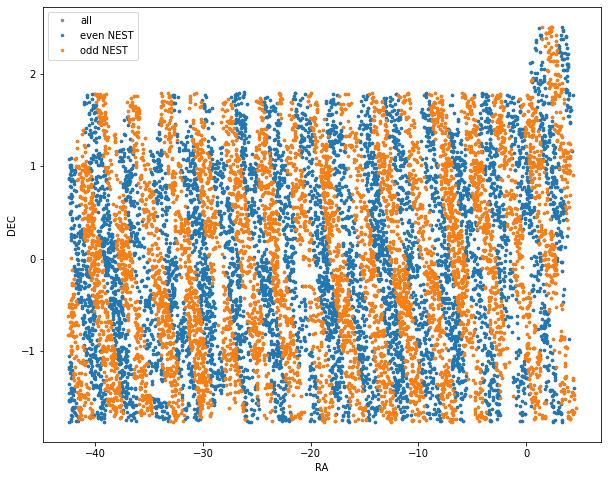

In [19]:
spatialcheck( [train_sample, train_even, train_odd], label = ['all', 'even NEST', 'odd NEST'] )

In [20]:
mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample['RA'], train_sample['DEC'], gold_st82['RA'], \
                                     gold_st82['DEC'],2./3600, maxmatch=1)
cmass_mask = np.zeros(gold_st82.size, dtype=bool)
cmass_mask[mg2] = 1
clean_cmass_data_des, nocmass = gold_st82[cmass_mask], gold_st82[~cmass_mask]
print('cmass_fraction even', clean_cmass_data_des.size *1./gold_st82.size)
fraction_even = clean_cmass_data_des.size *1./gold_st82.size

cmass_fraction even 0.01819935922819396


In [21]:
# use this one?

mg1, mg2, _ = esutil.htm.HTM(10).match(train_even['RA'], train_even['DEC'], gold_st82_even['RA'], \
                                     gold_st82_even['DEC'],2./3600, maxmatch=1)
cmass_mask_even = np.zeros(gold_st82_even.size, dtype=bool)
cmass_mask_even[mg2] = 1
clean_cmass_data_des_even, nocmass_even = gold_st82_even[cmass_mask_even], gold_st82_even[~cmass_mask_even]
print('cmass_fraction even', clean_cmass_data_des_even.size *1./gold_st82_even.size)
fraction_even = clean_cmass_data_des_even.size *1./gold_st82_even.size

cmass_fraction even 0.018252545977658307


In [22]:
nocmass_even.size, clean_cmass_data_des_even.size

(340202, 6325)

In [23]:
mg1, mg2, _ = esutil.htm.HTM(10).match(train_odd['RA'], train_odd['DEC'], gold_st82_odd['RA'], \
                                     gold_st82_odd['DEC'],2./3600, maxmatch=1)
cmass_mask_odd = np.zeros(gold_st82_odd.size, dtype=bool)
cmass_mask_odd[mg2] = 1
clean_cmass_data_des_odd, nocmass_odd = gold_st82_odd[cmass_mask_odd], gold_st82_odd[~cmass_mask_odd]
print('cmass_fraction odd', clean_cmass_data_des_odd.size *1./gold_st82_odd.size)
fraction_odd = clean_cmass_data_des_odd.size *1./gold_st82_odd.size

cmass_fraction odd 0.01814638969041351


In [24]:
gold_st82 = None
train_sample = None

In [ ]:
#already done
'''cmass_pickle = rootdir2+'gold_st82_XD_cmass_NEST_even2.pkl'
init_cmass_pickle = rootdir2+'gold_st82_XD_cmass_NEST_even.pkl' #'../output/sfd_train_photo_SamPle_nozband_ran10_3/gold_st82_XD_cmass.pkl'
clf_cmass_st82 = XD_fitting( data = clean_cmass_data_des_even, pickleFileName = cmass_pickle , init_params = init_cmass_pickle, 
                    n_cl = 10, n_iter = 5000, tol = 1e-5, verbose = True)'''

In [ ]:
no_pickle = rootdir2+'gold_st82_XD_no_NEST_even4.pkl'
#init_pickle = rootdir2+'gold_st82_XD_no_NEST_even.pkl'# '../output/sfd_train_photo_SamPle_nozband_ran10_3/gold_st82_XD_no.pkl'
init_pickle = None
clf_no_st82 = XD_fitting( data = nocmass_even, pickleFileName = no_pickle , init_params = init_pickle, 
                    n_cl = 10, n_iter = 2000, tol = 1e-5, verbose = True)

In [ ]:
'''cmass_pickle_odd = rootdir2 + 'gold_st82_XD_cmass_NEST_odd2.pkl'
init_cmass_pickle =  rootdir2 + 'gold_st82_XD_cmass_NEST_odd.pkl' # '../output/sfd_train_photo_SamPle_nozband_ran10_3/gold_st82_XD_cmass.pkl'
#init_cmass_pickle = None
clf_cmass_st82 = XD_fitting( data = clean_cmass_data_des_odd, pickleFileName = cmass_pickle_odd , init_params = init_cmass_pickle, 
                    n_cl = 10, n_iter = 5000, tol = 1e-5, verbose = True)'''

In [ ]:
'''no_pickle_odd = rootdir2 + 'gold_st82_XD_no_NEST_odd2.pkl'
init_pickle = rootdir2+'gold_st82_XD_no_NEST_odd.pkl' #'../output/sfd_train_photo_SamPle_nozband_ran10_3/gold_st82_XD_no.pkl'
#init_pickle = None
clf_no_st82 = XD_fitting( data = nocmass_odd, pickleFileName = no_pickle_odd , init_params = init_pickle, 
                    n_cl = 10, n_iter = 1000, tol = 1e-5, verbose = True)'''

In [ ]:
# even/odd, nest/ring --- only one pair of pickle files